In [1]:
siteinfo_file = 'flowdata/siteinfo.tsv'
quantiles = (0.1,0.2,0.3,0.5,0.7,0.8,0.9)
years_around_quantile = 5

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from adjustText import adjust_text

import streamutil

In [2]:
siteinfo_gdf = streamutil.get_site_info_gdf(siteinfo_file)
siteinfo_gdf

,Agency,Full Name,Name,geometry
Site,,,,
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481)
12048000,USGS,"DUNGENESS RIVER NEAR SEQUIM, WA",Dungeness River,POINT (-123.13268 48.01426)
12052000,USGS,"LITTLE QUILCENE RIVER NEAR QUILCENE, WA",Little Quilcene River,POINT (-122.88739 47.83731)
12052210,USGS,BIG QUILCENE RIVER BELOW DIVERSION NR QUILCENE...,Big Quilcene River,POINT (-122.97961 47.78454)
12053000,USGS,"DOSEWALLIPS RIVER NEAR BRINNON, WA",Dosewallips River,POINT (-123.00961 47.7262)
12054000,USGS,"DUCKABUSH RIVER NEAR BRINNON, WA",Duckabush River,POINT (-123.01155 47.68398)
12059500,USGS,"NORTH FORK SKOKOMISH RIVER NEAR POTLATCH, WA",North Fork Skokomish River,POINT (-123.24321 47.32981)
12060500,USGS,"SOUTH FORK SKOKOMISH RIVER NEAR UNION, WA",South Fork Skokomish River,POINT (-123.28016 47.34037)
12063500,USGS,"UNION RIVER NEAR BELFAIR, WA",Union River,POINT (-122.82737 47.47204)


In [3]:
all_flows = pd.concat(streamutil.get_all_flows("flowdata", siteinfo_gdf).values())
all_flows.head()

,Agency,Site,Flow,Flags
Date,,,,
2008-10-02,USGS,12210000,5.77728,A
2008-10-03,USGS,12210000,6.23040,A
2008-10-04,USGS,12210000,13.82016,A
2008-10-05,USGS,12210000,22.85424,A
2008-10-06,USGS,12210000,12.51744,A


1. Filter so I have just the streams that have at least 50 years of data
2. Compute correlations and linear least-squares fitting parameters between the streams
3. On a copy of the dataframe, fill in missing data using highest correlated stream's value for that day

In [4]:
long_term_sites = (all_flows.groupby('Site')['Flow'].count() / 365 > 50)
long_term_sites = long_term_sites.loc[long_term_sites]
long_term_siteinfo = siteinfo_gdf.loc[long_term_sites.index]
long_term_siteinfo

,Agency,Full Name,Name,geometry
Site,,,,
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481)
12048000,USGS,"DUNGENESS RIVER NEAR SEQUIM, WA",Dungeness River,POINT (-123.13268 48.01426)
12054000,USGS,"DUCKABUSH RIVER NEAR BRINNON, WA",Duckabush River,POINT (-123.01155 47.68398)
12059500,USGS,"NORTH FORK SKOKOMISH RIVER NEAR POTLATCH, WA",North Fork Skokomish River,POINT (-123.24321 47.32981)
12060500,USGS,"SOUTH FORK SKOKOMISH RIVER NEAR UNION, WA",South Fork Skokomish River,POINT (-123.28016 47.34037)
12073500,USGS,"HUGE CREEK NEAR WAUNA, WA",Huge Creek,POINT (-122.69902 47.38926)
12089500,USGS,"NISQUALLY RIVER AT MCKENNA, WA",Nisqually River,POINT (-122.56096 46.93343)
12101500,USGS,"PUYALLUP RIVER AT PUYALLUP, WA",Puyallup River,POINT (-122.32707 47.20843)
12113000,USGS,"GREEN RIVER NEAR AUBURN, WA",Green River,POINT (-122.20401 47.31232)


In [5]:
long_term_site_flows = {}
for site in long_term_sites.index:
    long_term_site_flows[site] = all_flows.loc[all_flows['Site'] == site, 'Flow']
long_term_site_flows_df = pd.DataFrame(long_term_site_flows)

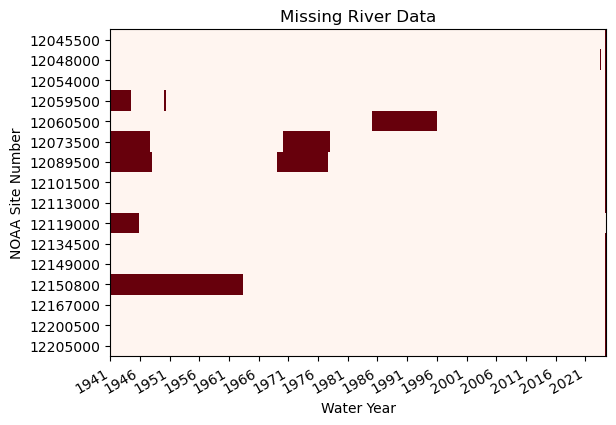

In [6]:
def show_missing_data(df, sites=None):
    if sites is None:
        sites = df.columns
    fig, ax = plt.subplots()
    ax.imshow(np.array([df[s].isna().astype(int) for s in sites]), aspect='auto', interpolation='none', cmap='Reds', vmin=0, vmax=1)
    ax.set_yticks(range(len(sites)))
    ax.set_yticklabels([str(s) for s in sites])

    # Find the indices of Oct 1 of each year
    junk, wy_starts = np.nonzero([(df.index.month == 10) & (df.index.day == 1)])
    ax.xaxis.set_major_locator(mticker.FixedLocator(wy_starts[0::5]))

    ax.xaxis.set_major_formatter(lambda x, pos: df.index[x].year+1)
    ax.set(title="Missing River Data", xlabel="Water Year", ylabel="NOAA Site Number")
    fig.autofmt_xdate()
    return fig, ax

show_missing_data(long_term_site_flows_df);

In [7]:
corrs = long_term_site_flows_df.corr()
corrs.replace({1: np.nan}, inplace=True)
corrs

,12045500,12048000,12054000,12059500,12060500,12073500,12089500,12101500,12113000,12119000,12134500,12149000,12150800,12167000,12200500,12205000
12045500,NaN,0.910034,0.893814,0.558547,0.780456,0.616928,0.518168,0.670865,0.572707,0.520498,0.799880,0.705480,0.762354,0.762295,0.768284,0.684245
12048000,0.910034,NaN,0.837392,0.439020,0.585359,0.500567,0.400027,0.617681,0.446115,0.400345,0.738652,0.601468,0.682046,0.590986,0.770160,0.772466
12054000,0.893814,0.837392,NaN,0.538301,0.828964,0.573014,0.439330,0.548084,0.472480,0.417713,0.670388,0.602419,0.635489,0.697392,0.618477,0.608321
12059500,0.558547,0.439020,0.538301,NaN,0.640051,0.627884,0.508138,0.410718,0.442444,0.458879,0.393228,0.456356,0.460212,0.525192,0.386048,0.178016
12060500,0.780456,0.585359,0.828964,0.640051,NaN,0.745983,0.565400,0.520617,0.558534,0.508844,0.571615,0.626008,0.615414,0.801595,0.455476,0.290499
12073500,0.616928,0.500567,0.573014,0.627884,0.745983,NaN,0.651038,0.529006,0.547775,0.555797,0.456916,0.561280,0.529638,0.632259,0.395369,0.143175
12089500,0.518168,0.400027,0.439330,0.508138,0.565400,0.651038,NaN,0.752911,0.758202,0.772506,0.493925,0.686412,0.658601,0.571153,0.491787,0.109826
12101500,0.670865,0.617681,0.548084,0.410718,0.520617,0.529006,0.752911,NaN,0.843162,0.762855,0.778682,0.875903,0.872252,0.687639,0.733519,0.439304
12113000,0.572707,0.446115,0.472480,0.442444,0.558534,0.547775,0.758202,0.843162,NaN,0.845919,0.660115,0.836636,0.831310,0.680049,0.599197,0.193469
12119000,0.520498,0.400345,0.417713,0.458879,0.508844,0.555797,0.772506,0.762855,0.845919,NaN,0.544114,0.733864,0.739307,0.584241,0.539414,0.120405


In [8]:
top_stream = corrs.idxmax()
top_stream

12045500    12048000
12048000    12045500
12054000    12045500
12059500    12060500
12060500    12054000
12073500    12060500
12089500    12119000
12101500    12149000
12113000    12119000
12119000    12113000
12134500    12150800
12149000    12150800
12150800    12149000
12167000    12149000
12200500    12150800
12205000    12048000
dtype: int64

In [9]:
# Compute all the estimates, then use fillna to fill the original DF with them.
# If they're both done in one pass, we can end up with estimates based on
# estimates
estimates = {}
for site in long_term_sites.index:
    x = long_term_site_flows_df[top_stream.loc[site]]
    y = long_term_site_flows_df[site]
    # NaNs confuse linregress. So build an intermediate DataFrame of x and y then run dropna
    xydf = pd.DataFrame({'x': x, 'y': y}).dropna()
    b1, b0, r, p, sb1 = stats.linregress(xydf['x'], xydf['y'])
    estimates[site] = b1 * x + b0

estimates_df = pd.DataFrame(estimates)

How much coverage is there in the estimates?

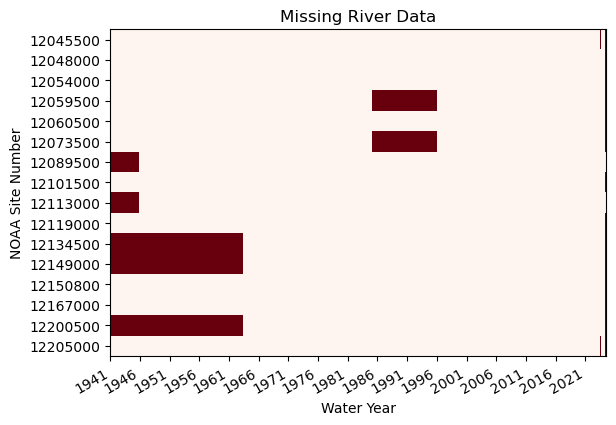

In [10]:
show_missing_data(estimates_df);

In [11]:
ltsites_est = {}
#ltsites_est_df = long_term_site_flows_df.fillna(estimates_df)
used_estimates = []
for site in long_term_sites.index:
    ltsites_est[site] = long_term_site_flows_df[site].fillna(estimates_df[site])
    days_added = len(ltsites_est[site].dropna()) - len(long_term_site_flows_df[site].dropna())
    if days_added > 0:
        print(f'Fill {days_added} missing days for {site} using {top_stream[site]}')
        used_estimates.append(top_stream[site])
ltsites_est_df = pd.DataFrame(ltsites_est)

Fill 6 missing days for 12048000 using 12045500
Fill 1389 missing days for 12059500 using 12060500
Fill 4017 missing days for 12060500 using 12054000
Fill 5387 missing days for 12073500 using 12060500
Fill 4067 missing days for 12089500 using 12119000
Fill 2 missing days for 12101500 using 12149000
Fill 140 missing days for 12113000 using 12119000
Fill 1797 missing days for 12119000 using 12113000
Fill 1 missing days for 12149000 using 12150800
Fill 8163 missing days for 12150800 using 12149000
Fill 2 missing days for 12167000 using 12149000
Fill 7 missing days for 12205000 using 12048000


Some streams have no data for Oct 1 of the first year they were active. Gain an extra year from these sites by just copying the Oct 2 value to Oct 1 in this case.

In [12]:
for site in long_term_sites.index:
    start_date = ltsites_est_df[site].first_valid_index()
    if start_date.month == 10 and start_date.day == 2:
        print(f'Backfilling {start_date} for site {site}')
        ltsites_est_df.loc[(ltsites_est_df.index == start_date - pd.to_timedelta(1, 'D')), site] = ltsites_est_df.loc[start_date, site]

Backfilling 1940-10-02 00:00:00 for site 12045500
Backfilling 1940-10-02 00:00:00 for site 12048000
Backfilling 1940-10-02 00:00:00 for site 12054000
Backfilling 1940-10-02 00:00:00 for site 12059500
Backfilling 1940-10-02 00:00:00 for site 12060500
Backfilling 1940-10-02 00:00:00 for site 12073500
Backfilling 1940-10-02 00:00:00 for site 12200500
Backfilling 1940-10-02 00:00:00 for site 12205000


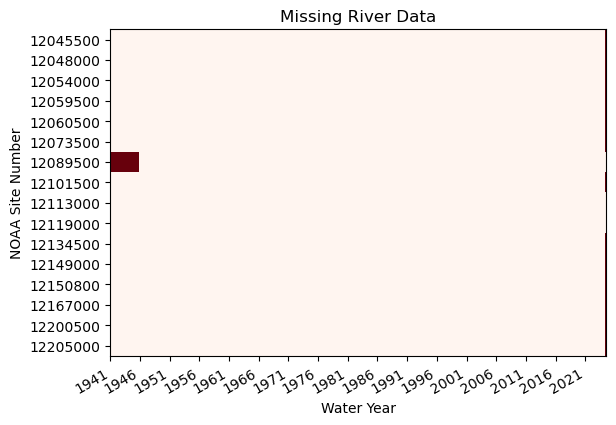

In [13]:
show_missing_data(ltsites_est_df);

4. Sum the flows over water year periods, preserving remaining NaNs
5. Drop any water years where at least one stream had a NaN
6. Compute the average total annual flow for each stream, using that value to create a ranking of streams

In [14]:
totals = ltsites_est_df.groupby(ltsites_est_df.index.to_period('Y-SEP')).agg(lambda x: x.sum(skipna=False) * 86400)
complete_totals = totals.dropna()
mean_annual_flow = complete_totals.mean()
mean_annual_flow.name = 'Annual Flow'
siteinfo_top = siteinfo_gdf.join(mean_annual_flow, how='inner').sort_values('Annual Flow', ascending=False)
siteinfo_top

,Agency,Full Name,Name,geometry,Annual Flow
12200500,USGS,"SKAGIT RIVER NEAR MOUNT VERNON, WA",Skagit River,POINT (-122.33544 48.44483),1.511492e+10
12150800,USGS,"SNOHOMISH RIVER NEAR MONROE, WA",Snohomish River,POINT (-122.04846 47.83093),8.789324e+09
12134500,USGS,"SKYKOMISH RIVER NEAR GOLD BAR, WA",Skykomish River,POINT (-121.66678 47.83733),3.671069e+09
12149000,USGS,"SNOQUALMIE RIVER NEAR CARNATION, WA",Snoqualmie River,POINT (-121.9254 47.66593),3.375910e+09
12101500,USGS,"PUYALLUP RIVER AT PUYALLUP, WA",Puyallup River,POINT (-122.32707 47.20843),3.049443e+09
12167000,USGS,"NF STILLAGUAMISH RIVER NEAR ARLINGTON, WA",Nf Stillaguamish River,POINT (-122.04764 48.26149),1.756103e+09
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481),1.387838e+09
12113000,USGS,"GREEN RIVER NEAR AUBURN, WA",Green River,POINT (-122.20401 47.31232),1.237926e+09
12089500,USGS,"NISQUALLY RIVER AT MCKENNA, WA",Nisqually River,POINT (-122.56096 46.93343),1.202087e+09
12205000,USGS,"NF NOOKSACK RIVER BL CASCADE CREEK NR GLACIER, WA",Nf Nooksack River,POINT (-121.84431 48.90596),7.252325e+08


7. Determine the first water year with complete data from estimations for each stream

In [15]:
for site in long_term_sites.index:
    siteinfo_top.loc[site, 'First Year'] = totals[site].first_valid_index()
siteinfo_top

,Agency,Full Name,Name,geometry,Annual Flow,First Year
12200500,USGS,"SKAGIT RIVER NEAR MOUNT VERNON, WA",Skagit River,POINT (-122.33544 48.44483),1.511492e+10,1941
12150800,USGS,"SNOHOMISH RIVER NEAR MONROE, WA",Snohomish River,POINT (-122.04846 47.83093),8.789324e+09,1941
12134500,USGS,"SKYKOMISH RIVER NEAR GOLD BAR, WA",Skykomish River,POINT (-121.66678 47.83733),3.671069e+09,1941
12149000,USGS,"SNOQUALMIE RIVER NEAR CARNATION, WA",Snoqualmie River,POINT (-121.9254 47.66593),3.375910e+09,1941
12101500,USGS,"PUYALLUP RIVER AT PUYALLUP, WA",Puyallup River,POINT (-122.32707 47.20843),3.049443e+09,1941
12167000,USGS,"NF STILLAGUAMISH RIVER NEAR ARLINGTON, WA",Nf Stillaguamish River,POINT (-122.04764 48.26149),1.756103e+09,1941
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481),1.387838e+09,1941
12113000,USGS,"GREEN RIVER NEAR AUBURN, WA",Green River,POINT (-122.20401 47.31232),1.237926e+09,1941
12089500,USGS,"NISQUALLY RIVER AT MCKENNA, WA",Nisqually River,POINT (-122.56096 46.93343),1.202087e+09,1946
12205000,USGS,"NF NOOKSACK RIVER BL CASCADE CREEK NR GLACIER, WA",Nf Nooksack River,POINT (-121.84431 48.90596),7.252325e+08,1941


Now we know which rivers are most important, and how far back the data go for them.

The top rivers by flow (m3) into Puget Sound are, in descending order and grouped by order of magnitude:
 * ~1e10: Skagit, Snohomish. Data from 1941 onward (with estimating Snohomish using Snoqualmie+Skykomish)
 * ~1e9: Puyallup, Stillaguamish, Green, Nisqually, Nooksack (probably), Skokomish. Data from 1946 onward due to Nisqually (from 1946-48 data is estimated from a nearby source)
 * ~1e8: Cedar, Duckabush, Dungeness. Data from 1941 onward

We still need to implement an estimation for Snohomish using Snoqualmie+Skykomish data. I also only have NF Nooksack data, so that will have to do.

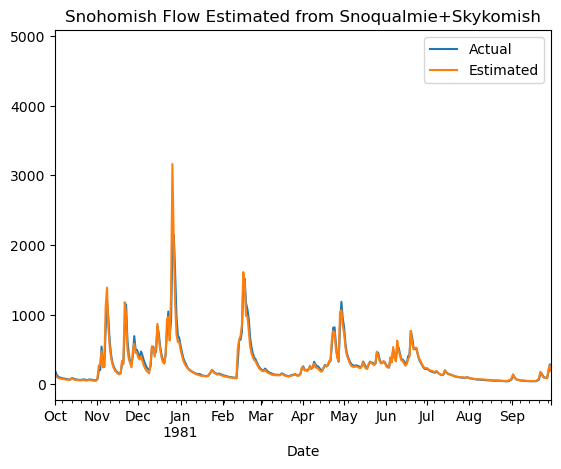

In [16]:
def est_from_sum(donors, recipient=None):
    """Estimate flow by summing all donor gauges and adjusting by ratio of long-term average annual flows"""
    total_donor_annual_flow = np.sum([siteinfo_top.loc[s, 'Annual Flow'] for s in donors])
    if recipient is not None:
        dar = siteinfo_top.loc[recipient, 'Annual Flow'] / total_donor_annual_flow
    else:
        dar = 1
    return dar * pd.DataFrame([ltsites_est_df[s] for s in donors]).sum(axis=0, skipna=False)

est_snohomish = est_from_sum([12134500, 12149000], 12150800)
fig, ax = plt.subplots()
ltsites_est_df[12150800].plot(ax=ax, label='Actual')
est_snohomish.plot(ax=ax, label='Estimated')
ax.set_xbound(pd.Timestamp('1980-10-01'), pd.Timestamp('1981-09-30'))
ax.set_title('Snohomish Flow Estimated from Snoqualmie+Skykomish')
ax.legend()

In [17]:
ltsites_est_df[12150800] = long_term_site_flows_df[12150800].fillna(est_snohomish)

In [18]:
included_sites = (12200500, 12150800, 12101500, 12167000, 12113000, 12089500,
                  12205000, 12060500, 12119000, 12054000, 12048000, 12059500)

In [19]:
source_sites = set(included_sites) | {12134500, 12149000} | set(used_estimates)
siteinfo_gdf.loc[list(source_sites)]

,Agency,Full Name,Name,geometry
Site,,,,
12048000,USGS,"DUNGENESS RIVER NEAR SEQUIM, WA",Dungeness River,POINT (-123.13268 48.01426)
12205000,USGS,"NF NOOKSACK RIVER BL CASCADE CREEK NR GLACIER, WA",Nf Nooksack River,POINT (-121.84431 48.90596)
12149000,USGS,"SNOQUALMIE RIVER NEAR CARNATION, WA",Snoqualmie River,POINT (-121.9254 47.66593)
12150800,USGS,"SNOHOMISH RIVER NEAR MONROE, WA",Snohomish River,POINT (-122.04846 47.83093)
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481)
12060500,USGS,"SOUTH FORK SKOKOMISH RIVER NEAR UNION, WA",South Fork Skokomish River,POINT (-123.28016 47.34037)
12119000,USGS,"CEDAR RIVER AT RENTON, WA",Cedar River,POINT (-122.20345 47.4826)
12167000,USGS,"NF STILLAGUAMISH RIVER NEAR ARLINGTON, WA",Nf Stillaguamish River,POINT (-122.04764 48.26149)
12089500,USGS,"NISQUALLY RIVER AT MCKENNA, WA",Nisqually River,POINT (-122.56096 46.93343)


How much data are we still missing?

,Start Date,End Date,Missing
12200500,1940-10-01,2023-11-28,0
12150800,1940-10-01,2023-11-20,0
12101500,1940-10-01,2023-11-28,0
12167000,1940-10-01,2023-11-20,0
12113000,1940-10-01,2024-04-16,0
12089500,1945-09-02,2024-04-16,0
12205000,1940-10-01,2023-11-19,1
12060500,1940-10-01,2023-11-19,0
12119000,1940-10-01,2024-04-16,0
12054000,1940-10-01,2023-11-19,0


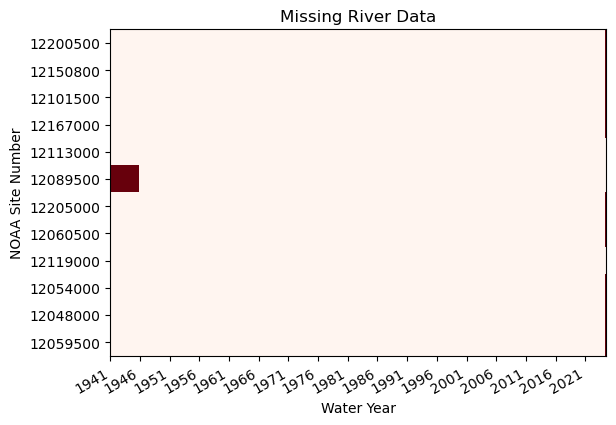

In [20]:
def site_stats(df, sites):
    starts = []
    ends = []
    missing_cts = []
    for s in sites:
        pruned = df[s].dropna()
        dates = pruned.index.sort_values()
        starts.append(dates[0])
        ends.append(dates[-1])
        missing_cts.append(len(pd.date_range(dates[0], dates[-1], freq="1D").difference(pruned.index)))
    return pd.DataFrame({"Start Date": starts,
                         "End Date": ends,
                         "Missing": missing_cts
                        }, index=included_sites)

show_missing_data(ltsites_est_df, included_sites)
site_stats(ltsites_est_df, included_sites)

Now we can construct a climatology that estimates total (relative) Puget Sound freshwater flow from 1946 onward.

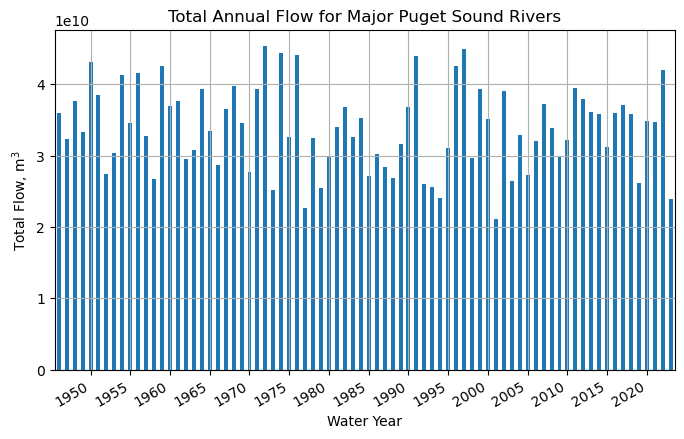

In [21]:
repr_flows_df = ltsites_est_df[list(included_sites)].dropna()
water_year_totals = repr_flows_df.groupby(repr_flows_df.index.to_period('Y-SEP')).sum().sum(axis=1) * 86400
# Drop the first and last years as they're incomplete
water_year_totals.drop(water_year_totals.index[0], inplace=True)
water_year_totals.drop(water_year_totals.index[-1], inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))
water_year_totals.plot.bar(ax=ax)
ax.xaxis.set_major_locator(mticker.IndexLocator(base=5, offset=4.25))
ax.xaxis.set_major_formatter(lambda x, pos: water_year_totals.index[int(x)])
ax.set(title="Total Annual Flow for Major Puget Sound Rivers", xlabel="Water Year", ylabel="Total Flow, m$^3$")
ax.grid()
fig.autofmt_xdate()

Create a Cunanne quantile plot that ranks the years

,0.1,0.2,0.3,0.5,0.7,0.8,0.9
0,1992,1970,1953,2008,1960,1971,1996
1,2019,1987,1986,1981,2017,2002,2022
2,1993,1952,1963,1965,1990,1964,1959
3,2003,1966,1980,1955,2007,1951,1956
4,1979,2005,1995,1949,1982,1999,1950


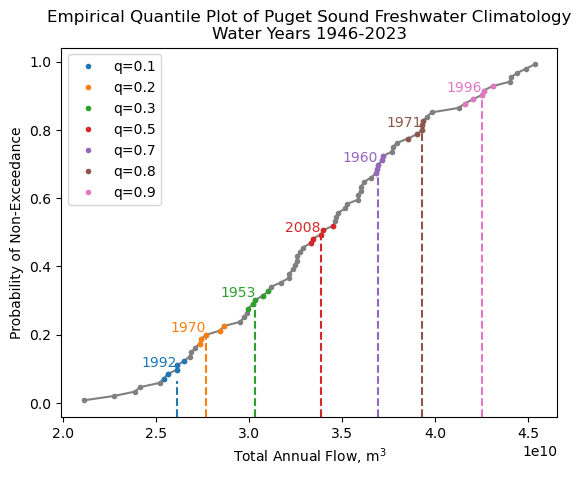

In [22]:
totals = pd.DataFrame({'Total': water_year_totals})
totals['plotting'] = stats.mstats.plotting_positions(water_year_totals)
totals_ranked = totals.sort_values('Total')
quantile_years = {}
fig, ax = plt.subplots()
ax.plot(totals_ranked['Total'], totals_ranked['plotting'], '.-', color='gray')
# Now find the years clustered around particular quantiles of interest.
# Plot them in separate colors and label the representative years
for quant in quantiles:
    nearby = totals.sort_values('plotting', key=lambda x: np.abs(x - quant)).head(years_around_quantile)
    quantile_years[quant] = nearby.index.year
    nearby_ranked = nearby.sort_index()
    l = ax.plot(nearby_ranked['Total'], nearby_ranked['plotting'], '.', label=f'q={quant}')
    closest = nearby.iloc[0]
    ax.axvline(closest['Total'],
               ymax=ax.transAxes.inverted().transform(ax.transData.transform([0, closest['plotting']]))[1],
               color=l[0].get_color(), linestyle='--')
    ax.annotate(str(closest.name), xy=(closest['Total'], closest['plotting']),
                va='bottom', ha='right', color=l[0].get_color())
ax.legend()
ax.set(title=f'Empirical Quantile Plot of Puget Sound Freshwater Climatology\nWater Years {water_year_totals.index[0]}-{water_year_totals.index[-1]}',
       ylabel='Probability of Non-Exceedance',
       xlabel='Total Annual Flow, m$^3$')
quantile_years_df = pd.DataFrame(quantile_years)
quantile_years_df

In [23]:
repr_flows_df.to_excel('data/river_climatology.xlsx')
quantile_years_df.to_excel('data/quantile_years.xlsx', index=False)

Create an average daily hydrograph of each stream across all available years

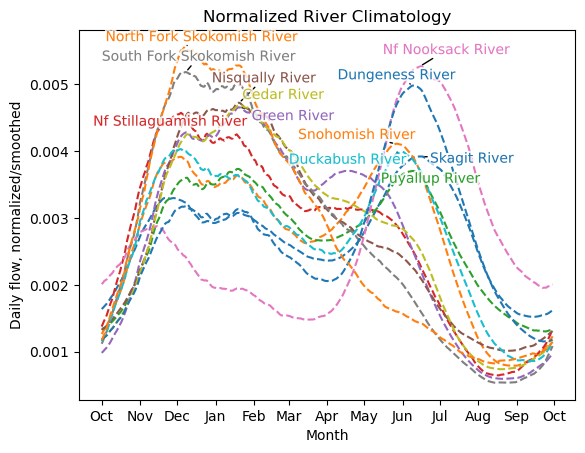

In [24]:
climatology = repr_flows_df.copy()
climatology['doy'] = repr_flows_df.index.dayofyear
# Drop leap days and fix dayofyear alignment
noleap_indexer = ~((climatology.index.month == 2) & (climatology.index.day == 29))
climatology.loc[climatology.index.is_leap_year & (climatology.index.month >= 3), 'doy'] -= 1
# Realign day of year
climatology['doy'] = (climatology['doy'] + 91) % 365 + 1
climatology = climatology.loc[noleap_indexer]

mean_daily_climatology = climatology.groupby('doy').mean()
# rolling average will cut off ends of the water year. To prevent this, append data to the start and end matching the end and start
for i in range(-15, 0):
    mean_daily_climatology.loc[i] = mean_daily_climatology.iloc[i]
    mean_daily_climatology.sort_index(inplace=True)
for i in range(1, 15):
    mean_daily_climatology.loc[365+i] = mean_daily_climatology.loc[i]
mean_daily_climatology = mean_daily_climatology.rolling(30, center=True).mean().dropna()

for c in mean_daily_climatology.columns:
    mean_daily_climatology[c] /= mean_daily_climatology[c].sum()
# set a datetimeindex as the index
mean_daily_climatology.reset_index(inplace=True)
mean_daily_climatology.set_index(pd.date_range('2000-10-01', '2001-09-30'), inplace=True)

fig, ax = plt.subplots()
texts = []
for c in mean_daily_climatology.columns:
    if c == 'doy':
        continue
    l = ax.plot(mean_daily_climatology.index, mean_daily_climatology[c], '--')
    # If there's a late peak, label it. Otherwise label the winter peak
    allpeaks, junk = find_peaks(mean_daily_climatology[c].values, prominence=.0008)
    if allpeaks.max() > 200:
        lblpeak = (mean_daily_climatology.loc[mean_daily_climatology['doy'] == allpeaks.max()].index[0],
                   mean_daily_climatology[c].iloc[allpeaks.max()])
    else:
        lblpeak = (mean_daily_climatology[c].idxmax(), mean_daily_climatology[c].max())
    texts.append(ax.annotate(siteinfo_top.loc[c, 'Name'], ha='center', color=l[0].get_color(),
                             xy=lblpeak,
                             path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.8)]
                            )
                )
ax.set(xlabel='Month', ylabel='Daily flow, normalized/smoothed',
       title='Normalized River Climatology')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
adjust_text(texts, arrowprops=dict(arrowstyle='-'))